## 載入預訓練模型(ResNet50)
ResNet50 突破了深度神經網路 Deep 的受限，引入了殘差學習的概念。通常隨著神經網路層數的增加，模型的性能會變得更好，但在一定深度後，模型會遭遇梯度消失或梯度爆炸的問題，導致訓練變得困難。因此 ResNet 引入 Residual Block（殘差模塊）允許訊息在不同層之間跳躍（即跳過某些層），進而解決了這個問題。
![](https://ithelp.ithome.com.tw/upload/images/20231003/201072473HI4nKpZGt.png)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

# 建立一個輸入張量，指定圖像大小為224x224（RGB色彩通道）
input_tensor = Input(shape=(224, 224, 3))
# 建立 ResNet50 模型
model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=True)

![](https://i.imgur.com/EiV2Eo0.png)

#### 範例影像
- 鳳梨: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/pineapple.jpg?raw=true
- 香蕉: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/banana.jpg?raw=true
- 柳橙: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/orange.jpg?raw=true

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# 載入圖像
image_url = tf.keras.utils.get_file(origin='https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/pineapple.jpg?raw=true')
image = tf.keras.utils.load_img(image_url, target_size=(224, 224))
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# 預處理圖像
x = preprocess_input(x)

In [3]:
from tensorflow.keras.applications.resnet50 import decode_predictions

# 進行圖像分類預測
pred_proba = model.predict(x) # 返回分類機率
# 解析預測結果
pred_class_idx = pred_proba.argmax(axis=1)[0]  # 找到具有最高機率的類別索引
pred_class = decode_predictions(pred_proba, top=1)[0][0]  # 解析取得預測結果

1/1 [==============================] - 1s 789ms/step


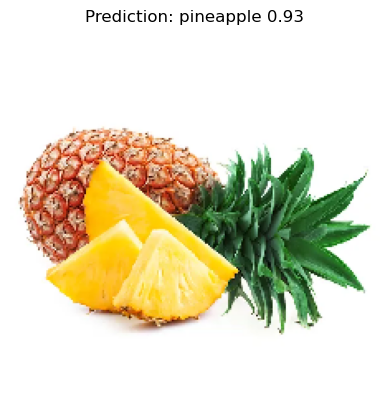

In [4]:
import matplotlib.pylab as plt

plt.imshow(image.astype('uint8'))
plt.axis('off')
predicted_class_name = pred_class[1]
plt.title(f"Prediction: {predicted_class_name} {pred_class[2]:.2f}")
plt.show()

## 使用 SHAP 解釋 CNN 模型
Partition Explainer 是 SHAP 套件中的一種方法，用於解釋機器學習模型。針對 CNN 模型的解釋，它可以用於分析圖像分類模型的決策。

In [6]:
!pip install shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:0000:0100:01


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# 載入圖像
image_url = tf.keras.utils.get_file(origin='https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/pineapple.jpg?raw=true')
image = tf.keras.utils.load_img(image_url, target_size=(224, 224))
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度

In [22]:
import json
import requests

# 下載 ImageNet 類別名稱的 JSON 檔案
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
response = requests.get(url)
class_names = [v[1] for v in response.json().values()]


  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:25, 85.68s/it]               


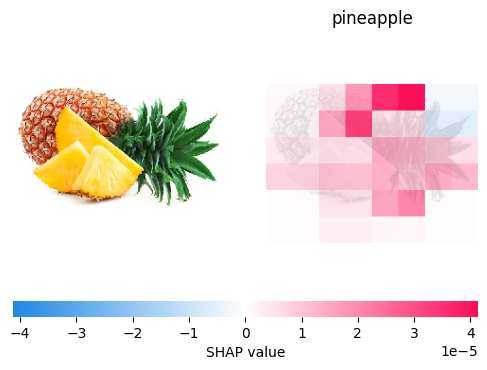

In [27]:
import shap

# 包裝要被解釋的模型
def f(X):
    tmp = X.copy()
    preprocess_input(tmp) # 影像前處理
    return model(tmp)

# 定義一個 masker 用於遮罩圖像的部分區域
masker = shap.maskers.Image("blur(5, 5)", x[0].shape)
# 使用 Partition explainer 解釋模型
explainer = shap.Explainer(f, masker, output_names=class_names)
# 估計 Shapely values
shap_values = explainer(x, max_evals=200, batch_size=1, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values, x.astype(np.uint8))